<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/2021-1_Deep_learning/T2_Recurrent_neural_networks(RNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TAREA 2:  REDES NEURONALES RECURRENTES (RNNS)
## IIC3697 - Aprendizaje Profundo

Departamento de Ciencia de la Computación

Pontificia Universidad Católica de Chile

Camila F. Vera Villa

# 0. SETUP INICIAL

Obtener memoria libre de la GPU

In [ ]:
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0] # Only one GPU on Colab and isn’t guaranteed
def printm():
    process = psutil.Process(os.getpid())
    print('Gen RAM Free: ' + humanize.naturalsize(
        psutil.virtual_memory().available),'IProcsize:'+
        humanize.naturalsize(process.memory_info().rss))
    print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total{3:.0f}MB'.format(
        gpu.memoryFree,gpu.memoryUsed, gpu.memoryUtil*100,gpu.memoryTotal))
printm()

Gen RAM Free: 13.3 GB IProcsize:55.5 MB
GPU RAM Free: 5671MB | Used: 407MB | Util   7% | Total6078MB


Instalación de librerías

In [ ]:
from IPython.display import clear_output
!pip install torch-summary
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda102]
!python -m spacy download en_core_web_sm
!pip install torchtext
!pip install gensim
!pip install textaugment
!pip install numpy nltk gensim textblob googletrans
!pip install nltk
clear_output()
print('Librerías instaladas.')

Librerías instaladas.


## Librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import re
import random
import copy
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
##### Pytorch
import torch.nn as nn
import torch
from torchtext import data
from torchtext.legacy import data
from torchtext import data
SEED = 25
torch.manual_seed(SEED)
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
from torch import nn, optim
from tqdm import tqdm
from os import listdir
from os.path import join

from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler

CUDA_LAUNCH_BLOCKING="1"
from torch.backends import cudnn
torch.backends.cudnn.deterministic = True

import warnings as wrn
wrn.filterwarnings('ignore')
#path = "/content/drive/MyDrive/Magíster en Ciencias de la Ingeniería UC/2021-1_Deep_learning/tarea2"
#from google.colab import drive
#drive.mount('/content/drive')

print("PyTorch Version: ",torch.__version__)
print('Librerías cargadas.')


/home/cami/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


PyTorch Version:  1.8.1+cu102
Librerías cargadas.


In [ ]:
path = "/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea2_deep_learning"

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print()

#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1060 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## I. PARTE 1: Redes Neuronales Recurrentes: RNNs (40%)

Las redes recurrentes permiten modelar secuencias, es decir, capturar relaciones de orden en los datos, por ejemplo, temporal o espacial. En esta tarea usaremos la librería PyTorch para nuestra implementación.
Considere la red recurrente representada en la figura 1.

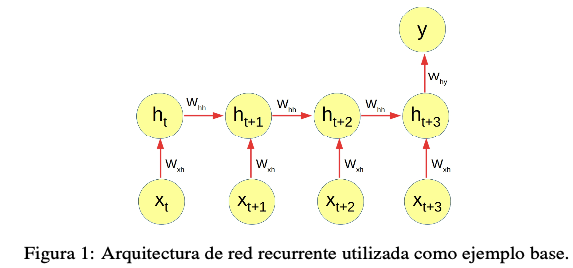

El siguiente código nos permite implementar la RNN de la figura 1 usando PyTorch.



```
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers):
    super().__init__()

  # Definir algunos parámetros
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
  # Define las capas
    # RNN Layer
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
    # Linear layer
    self.linear_out = nn.Linear(hidden_dim, 1)

  # This method defines the forward pass of the RNN
  def forward(self, input):
    batch_size, _ = input.size()

    # Initializing hidden state for first input
    h0 = self.init_hidden(batch_size) #h0 es una hidden

    # Passing in the input and hidden state to obtain output
    _, hidden_state = self.rnn(input.unsqueeze(2), h0)
    out = self.linear_out(hidden_state.squeeze())
    return out

  # This method generates the first hidden state of zeros for the forward pass
  # This creates a tensor of zeros in the shape of our hidden states.
  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden
```



El primer paso es crear una **clase RNN** que hereda de la clase base `nn.module` de PyTorch. La creación de nuestra clase RNN recibe como parámetros:

    i) el tamaño del input (input size)

    ii) el tamaño del estado oculto de la red recurrente (hidden size), y

    iii) la cantidad de capas de la red recurrente (num layers).

En el método constructor de la clase se crea una **instancia de nn.RNN**, que recibe como parámetros:

    i) el tamaño de los tensores de entrada (input size)

    ii) tamaño del estado oculto (hidden size) y

    iii) la cantidad de capas recurrentes (num layers).

 Adicionalmente, se crea una **capa lineal para producir la salida**. Esta capa de salida recibe como parámetro:

    i) la dimensión de entrada hidden dim y

    ii) la dimensión de salida, en este caso 1 y sin función de activació no-lineal.

Adicionalmente, es necesario definir el **método forward**, que es usado para definir las opciones de la alimentació́n secuencial de la red. En este caso, indicamos que la red recibe como entrada dos tensores: *input y initial hidden state*. El primero corresponde a las features de entrada y el segundo al estado inicial del estado oculto. Este segundo parámetro es opcional, y si no se entrega se inicializan los estados ocultos con valores iguales a cero.

El resultado de invocar a **self.rnn** corresponde a dos tensores: *output y hidden state.* El primero corresponde a todos los estados ocultos obtenidos luego de procesar la secuencia, mientras que el segundo solo contiene los últimos estados ocultos.

Finalmente, se define la **salida lineal,** como el modelo es del tipo* many–to–one*, solo se pasan los últimos estados ocultos de la RNN por la capa lineal para obtener la salida deseada.


Luego, ya podemos usar el modelo anterior, así como definir hiperparámetros, función de pérdida, optimizador y comenzar entrenamiento.



```
# Instanciar el modelo con hiperparámetros
model = RNN(input_size = 1, output_size = 1, hidden_dim = 80, n_layers = 60)

# Define hyperparameters: number of epochs and learning rate
n_epochs = 100
lr=0.01

# Define device, in this case CPU
device = torch.device("cpu")
model.to(device)

# Define Loss, Optimizer, ex: cross entropy and Adam.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Run training
for epoch in range(1, n_epochs + 1):
  for input_seq in batches:
    # Reset gradients from previous epoch
    optimizer.zero_grad()
    # run model on inputs
    input_seq.to(device)
    output, hidden = model(here-input-seq)
    # compute loss, run backprop, and update weights
    loss = criterion(output, here-output-seq.view(-1).long()) loss.backward()
    optimizer.step()
```



En esta parte de la tarea aplicaremos redes recurrentes para clasificar textos.

En particular, trabajaremos con el set de datos disponible en: SMS-Dataset. Este set de datos contiene 5000 SMS etiquetados según el rótulo **spam o no-spam**. Para el problema de clasificación de una secuencia de texto el primer paso será transformar cada oración de entrada a un espacio de característica (feature space o embedding).

Para esto deberán crear una **capa de embedding** que transforme las oraciones de entrada a un vector de largo fijo. Esta capa puede operar directamente sobre toda la oración de entrada, o puede operar sobre cada una de las palabras y luego generar un vector integrado mediante un proceso de pooling (ex. sumar los embedding de las palabras de la oración). Averigue sobre posibles codificaciones (embeddings) de oraciones y palabras, y seleccione una de ellas para su tarea.

En su implementación deberán considerar los largos de secuencia de los textos de entrada. Esto pues algunos son más extensos que otros pero su modelo espera batches en formato tensorial, lo que implica que las oraciones deben ser llevadas a un largo fijo. Para resolver este problema recomendamos usar la función **`PadSequence`**, aunque pueden obtener mejoras en el tiempo de entrenamiento e inferencia si usan la **abstracción PackedSequence.**


Para la estructura de su modelo use una configuración similar a la figura 1, i.e., ***sólo una capa oculta para la red recurrente y un clasificador conectado al estado final de la recurrencia.***

* Para el **estado oculto** de la red recurrente utilice **80 dimensiones**.

* Para el **clasificador** utilice una **capa densa de 60 neuronas** y **activación soft-max**.

## Actividad 1 - Explique embedding
Explique brevemente la técnica seleccionada para el embedding inicial de las oraciones del set de entrada.

Para obtener los embeddings iniciales de las oraciones del set de entrada, se utilizó Global Vectors for Word Representation(GloVe) glove.6B.100d.
Para esto primero se **preprocesaron** los datos reordenando las columnas y tokenizando con Spacy, luego se crean los campos Field para las columnas con texto, en donde se encuentra el mensaje (columna "message") y Labels para la columna donde están las etiquetas de cada mensaje, llamada Label.

**GloVe** es un algoritmo de aprendizaje no supervisado usado para obtener representaciones vectoriales de palabras. El entrenamiento se realiza en estadísticas globales de co-ocurrencia palabra-palabra agregadas de un corpus, y las representaciones resultantes muestran  subestructuras lineales del espacio vectorial de palabras.

El objetivo de entrenamiento de GloVe es aprender vectores de palabras de modo que su producto escalar sea igual al logaritmo de la probabilidad de co-ocurrencia de palabras.  Se costruyó por lo tanto, el vocabulario transformando los tokens en números enteros para que puedan ser leídos por el modelo.

### **Preprocesamiento de los datos**


Importación de datos SMS

In [ ]:
datos_sms = pd.read_table('SMSSpamCollection',
                   sep='\t',
                   header=None,
                   names=["label", 'message'])
datos_sms.label = datos_sms.label.map({'ham':0, 'spam':1})


In [ ]:
datos_sms.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Cambiar etiquetas **ham** y **spam** por numéricas

* 0 = ham
* 1 = spam

In [ ]:
datos_sms

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
datos_sms.to_csv('sms_wcommas.csv', index = False)

In [ ]:
datos_sms.isna().sum()

label      0
message    0
dtype: int64

In [ ]:
sms_wcommas = pd.read_csv('sms_wcommas.csv')

In [ ]:
sms_wcommas.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### **Tokenización usando TorchText y Spacy**

Creación de *Field* para especificar como se va a preprocesar un campo específico.

In [ ]:
import torch.nn.functional as F
import torchtext

In [ ]:
TEXT = torchtext.legacy.data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm', include_lengths=True)
LABEL = torchtext.legacy.data.LabelField(dtype = torch.long)

dataField=[("label",LABEL),("message",TEXT)]

In [ ]:
print(dataField)

[('label', <torchtext.legacy.data.field.LabelField object at 0x7f094e05d640>), ('message', <torchtext.legacy.data.field.Field object at 0x7f094e30e2e0>)]


Creación del **dataset** con **`TabularDataset()`**

In [ ]:
dataset= torchtext.legacy.data.TabularDataset("sms_wcommas.csv",
                            format='csv',fields=dataField, skip_header=True)

**Separación de conjuntos de train, validación y test** del dataset con el módulo `split` de `torchtext.data`

* train = 80%
* test = 20%

Luego para validación se usará el 15% de train

* validation = 15%


**Definición de hiperparámetros generales**

In [ ]:
VOCABULARY_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 80
NUM_CLASSES = 2
RANDOM_SEED = 25

Train y test

In [ ]:
train_data, test_data = dataset.split(split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Datos Train: {len(train_data)}')
print(f'Dtos Test: {len(test_data)}')

Datos Train: 4458
Dtos Test: 1114


Train y Validación

In [ ]:
train_data, val_data = train_data.split(split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

Revisión de datos y etiquetas

In [ ]:
print(len(dataset))
print(vars(train_data.examples[13]))

5572
{'label': '1', 'message': ['URGENT', '!', 'We', 'are', 'trying', 'to', 'contact', 'U.', 'Todays', 'draw', 'shows', 'that', 'you', 'have', 'won', 'a', '£', '800', 'prize', 'GUARANTEED', '.', 'Call', '09050001295', 'from', 'land', 'line', '.', 'Claim', 'A21', '.', 'Valid', '12hrs', 'only']}


### Embeding

**Carga de `embbeding`**  pre entrenado, con el uso del módulo *build_vocab()*
Representaciones vectoriales de palabras con GLoVe.

`TEXT.vocab.load_vectors('glove.6B.100d')`

Ref: https://nlp.stanford.edu/projects/glove/


**Construcción del vocabulario**

Se transforman los tokens a números enteros.

In [ ]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE, vectors = 'glove.6B.100d')
LABEL.build_vocab(train_data)
embedding = TEXT.vocab.vectors.to(DEVICE)

Shape del embedding

In [ ]:
embedding.shape

torch.Size([1002, 100])

In [ ]:
print(f'Vocabulary Size: {len(TEXT.vocab)}')
print(f'N° Classes: {len(LABEL.vocab)}')
print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(val_data)}')
print(f'Num Test: {len(test_data)}')

Vocabulary Size: 1002
N° Classes: 2
Num Train: 3789
Num Validation: 669
Num Test: 1114


**Iterador**

In [ ]:

train_loader, val_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, val_data, test_data),
        batch_size=BATCH_SIZE,
        sort_within_batch=True,
             sort_key=lambda x: len(x.message),
        device=DEVICE
)

Tamaño de los vectores y matrices para train,test y validation

In [ ]:

print('Train')
for batch in train_loader:
    print(f'Tamaño de la matriz message: {batch.message[0].size()}')
    print(f'Tamaño del vector label: {batch.label.size()}')
    break

print('\nValidation:')
for batch in val_loader:
    print(f'Tamaño de la matriz message: {batch.message[0].size()}')
    print(f'Tamaño del vector label: {batch.label.size()}')
    break

print('\nTest:')
for batch in test_loader:
    print(f'Tamaño de la matriz message: {batch.message[0].size()}')
    print(f'Tamaño del vector label: {batch.label.size()}')
    break

Train
Tamaño de la matriz message: torch.Size([33, 64])
Tamaño del vector label: torch.Size([64])

Validation:
Tamaño de la matriz message: torch.Size([6, 64])
Tamaño del vector label: torch.Size([64])

Test:
Tamaño de la matriz message: torch.Size([5, 64])
Tamaño del vector label: torch.Size([64])


## Actividad 2 - Implemente RNN simple
Implemente el modelo indicado usando una RNN simple:

• **¿Depende el número de parámetros del dataset utilizado?**

**Respuesta:** La Red Recurrente simple propuesta tiene como parámetros: Embedding con un tamaño de vocabulario de 1002 y vector de 100 dimensiones, 80 dimensiones para el estado oculto y una capa oculta Linear con función de activación LogSoftmax. El modelo en este caso sí depende del número de parámetros del dataset ya que incorpora la "variable" de dimensionalidad. En este caso el dataset pasó por un proceso de tokenización y se construyó el vocabulario transformando el token a un número entero. Las palabras fueron representadas por medio de vectores al usar GloVe, lo que permite escoger las dimensiones de la transformación.

Se utilizó para este caso (model_rnn) un vector de 100 dimensiones y se obtuvieron 114.922  parámetros entrenables, luego se hizo una prueba generando otro modelo (model_rnn_2) aumentando el tamaño del embbeding a 500 dimensiones y los parámetros del modelo  aumentaron(casi se quintuplicaron) a  547,722  parámetros entrenables. Por lo tanto, en este caso de estudio, sí depende el número de parámentros del dataset SMS.
(el código de prueba está en un par de celdas inferiores a esta)

• **¿Cómo se podría reducir los parámetros del modelo sin reducir la dimensionalidad del estado interno de la red?**

**Respuesta:** El modelo RNN simple  con 80 dimensiones para el estado oculto tiene 114,922  parámeteros entrenables. Se podría reducir los parámetros del modelo disminuyendo la representación vectorial del dataset en el embedding, generando un vocabulario menos numeroso. (el código de prueba está en un par de celdas inferiores a esta)

• **Se decide modificar la dimensionalidad del estado oculto de la red recurrente a un valor 120. ¿Cómo se ve afectado el número de parámetros?**
 Pruebe y fundamente su respuesta.

**Respuesta:** Se probó aumentando la dimensionalidad del estado oculto de la red a 120, quedano el modelo con 127,082  parámeteros entrenables. Con esta modificación hay 12.160 parámetros más que en el modelo con 80 dimensiones de estado oculto. (el código de prueba está en un par de celdas inferiores a esta)

`RNN(  (embedding): Embedding(1002, 100),   (rnn): RNN(100, 120),  (fc): Linear(in_features=120, out_features=2, bias=True), (act): LogSoftmax(dim=None) )`




### Implementación modelo RNN Simple (model_rnn)

In [ ]:
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim,
                               hidden_dim,
                               nonlinearity='relu')

        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.act = torch.nn.LogSoftmax()

    def forward(self, text, text_length):
        embedded = self.embedding(text)

        ## padded_sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'))
        packed_output, hidden = self.rnn(packed)

        hidden.squeeze_(0)
        output = self.fc(hidden)
        output=  self.act(output)
        return output

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_rnn = RNN(input_dim=len(TEXT.vocab),
            embedding_dim= 100,
            hidden_dim=HIDDEN_DIM,
            output_dim= 2 # 60? could use 1 for binary classification
)

model_rnn = model_rnn.to(DEVICE)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr= LEARNING_RATE)


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_rnn_2 = RNN(input_dim=len(TEXT.vocab),
            embedding_dim= 500,
            hidden_dim=HIDDEN_DIM,
            output_dim= 2 # 60? could use 1 for binary classification
)

model_rnn_2 = model_rnn_2.to(DEVICE)
optimizer = torch.optim.Adam(model_rnn_2.parameters(), lr= LEARNING_RATE)

Se decide modificar la dimensionalidad del estado oculto de la red recurrente a un valor 120. ¿Cómo se ve afectado
el número de parámetros? Pruebe y fundamente su respuesta.

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_rnn_120_hidden = RNN(input_dim=len(TEXT.vocab),
            embedding_dim= 100,
            hidden_dim= 120,
            output_dim= 2 # 60? could use 1 for binary classification
)

model_rnn_120_hidden = model_rnn_120_hidden.to(DEVICE)
optimizer = torch.optim.Adam(model_rnn_120_hidden.parameters(), lr= LEARNING_RATE)

In [ ]:
print(model_rnn_120_hidden)

RNN(
  (embedding): Embedding(1002, 100)
  (rnn): RNN(100, 120)
  (fc): Linear(in_features=120, out_features=2, bias=True)
  (act): LogSoftmax(dim=None)
)


#### **Cálculo de parámetros entrenables**

In [ ]:
print(model_rnn)

RNN(
  (embedding): Embedding(1002, 100)
  (rnn): RNN(100, 80)
  (fc): Linear(in_features=80, out_features=2, bias=True)
  (act): LogSoftmax(dim=None)
)


In [ ]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

**Cantidad de parámetros para el modelo con 80 dimensiones para el estado oculto**

In [ ]:
print(f'El modelo model_rnn tiene  {num_trainable_parameters(model_rnn):,}  parámeteros entrenables')


El modelo model_rnn tiene  114,922  parámeteros entrenables


**Cantidad de parámetros para el modelo con 80 dimensiones para el estado oculto y aumeando el vector de embedding**

In [ ]:
print(f'El modelo model_rnn_2 tiene  {num_trainable_parameters(model_rnn_2):,}  parámeteros entrenables')


El modelo model_rnn_2 tiene  547,722  parámeteros entrenables


**Cantidad de parámetros para el modelo con 120 dimensiones para el estado oculto**

In [ ]:
print(f'El modelo model_rnn_120_hidden tiene {num_trainable_parameters(model_rnn_120_hidden):,}  parámeteros entrenables')

El modelo model_rnn_120_hidden tiene 127,082  parámeteros entrenables


## Actividad 3 - Entrene
Entrene su modelo:

• Reporte gráficamente cómo varía la precisión y la función de pérdida conforme avanza el set entrenamiento.

• Reporte la precisión obtenida en el set de `test`.



Entrenamiento RNN

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch_data in enumerate(data_loader):

            # NEW
            features, text_length = batch_data.message
            targets = batch_data.label.to(DEVICE)

            logits = model(features, text_length)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
train_losses_rnn = []
accuracy_train_rnn = []
accuracy_test_rnn = []

for epoch in range(NUM_EPOCHS):
    model_rnn.train()
    for batch_idx, batch_data in enumerate(train_loader):

        # features y labels
        features, text_length = batch_data.message
        labels = batch_data.label.to(DEVICE)

        ### Forward y back propagation
        logits = model_rnn(features, text_length)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward(retain_graph = True)

        ### guardar loss y accuracy para gráficas
        train_losses_rnn.append(loss)
        accuracy_train_rnn.append(compute_accuracy(model_rnn, train_loader, DEVICE))
        accuracy_test_rnn.append(compute_accuracy(model_rnn, test_loader, DEVICE))

        ### actualización de los parámetros del modelo
        optimizer.step()

        ### cálculos
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model_rnn, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model_rnn, val_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model_rnn, test_loader, DEVICE):.2f}%')

<ipython-input-201-4366a9d9919b>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output=  self.act(output)


Epoch: 001/100 | Batch 000/060 | Loss: 0.8891
training accuracy: 35.26%
valid accuracy: 34.68%
Time elapsed: 0.00 min
Epoch: 002/100 | Batch 000/060 | Loss: 0.7777
training accuracy: 63.47%
valid accuracy: 60.69%
Time elapsed: 0.01 min
Epoch: 003/100 | Batch 000/060 | Loss: 0.6320
training accuracy: 76.17%
valid accuracy: 77.28%
Time elapsed: 0.01 min
Epoch: 004/100 | Batch 000/060 | Loss: 0.6065
training accuracy: 80.81%
valid accuracy: 81.91%
Time elapsed: 0.01 min
Epoch: 005/100 | Batch 000/060 | Loss: 0.5133
training accuracy: 83.35%
valid accuracy: 84.60%
Time elapsed: 0.02 min
Epoch: 006/100 | Batch 000/060 | Loss: 0.5509
training accuracy: 84.85%
valid accuracy: 86.25%
Time elapsed: 0.02 min
Epoch: 007/100 | Batch 000/060 | Loss: 0.3774
training accuracy: 86.20%
valid accuracy: 87.89%
Time elapsed: 0.02 min
Epoch: 008/100 | Batch 000/060 | Loss: 0.3507
training accuracy: 86.38%
valid accuracy: 88.19%
Time elapsed: 0.02 min
Epoch: 009/100 | Batch 000/060 | Loss: 0.3946
training a

**Gráficos de la función de pérdida y precisión durante el entrenamiento**

* Para la RNN entrenada con 100 epochs se logró un **accuracy en train de 86,80%** y **accuracy en validación de 88,79%** en la última época.
La función de pérdida se mantiene baja durante todo el entrenamiento,

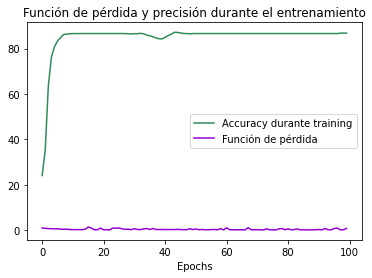

In [ ]:
plt.title('Función de pérdida y precisión durante el entrenamiento')
plt.plot(accuracy_train_rnn,color='seagreen')
plt.plot(train_losses_rnn, color='darkviolet')

plt.xlabel('Epochs')
plt.legend(['Accuracy durante training', 'Función de pérdida'], loc='center right')
plt.show()

- Para la RNN entrenada con 100 epochs se logró un **accuracy en test de 85.37%**

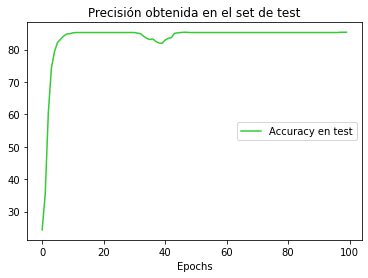

In [ ]:
plt.title('Precisión obtenida en el set de test')
plt.plot(accuracy_test_rnn,color='limegreen')
plt.xlabel('Epochs')
plt.legend(['Accuracy en test'], loc='center right')
plt.show()

## Actividad 4 - Comparar rendimiento LSTM/RNN tradicional
La red anterior implementa una red recurrente tradicional. Como comentamos en clase, el uso de una RNN tradicional presenta limitaciones para ajustar los parámetros de la red utilizando métodos de descenso de gradiente (problema de desvanecimiento o explosión de gradientes vanishing/exploiting gradient problems).
Redes recurrentes tipo LSTM o GRU ofrecen soluciones más estables. PyTorch ofrece implementaciones de ambas alternativas, siendo muy simple su uso.

• **Compare el rendimiento de un modelo LSTM con respecto al modelo tradicional de RNN. Considere el rendimiento en términos de calidad de predicción y también el número de parámetros utilizados.
Comente brevemente sus resultados.**

**Respuesta:** Para el modelo tradicional de RNN entrenada con 100 epochs se logró un accuracy en test de 85.37%, con 114,922 parámeteros entrenables. El modelo LSTM  logró un accuracy en test de 97.04%, con  158,602  parámetros entrenables. Como podemos ver LSTM tuvo mucho mejor rendimiento en accuracy y en tiempo de ejecución solo tardó 2 segundos más para las mismas 100 épocas. A contiuación una tabla comparativa resumen del desempeño de ambos modelos.

|                        | RNN tradicional |   LSTM   |
|------------------------|:---------------:|:--------:|
| training accuracy      |      86.80%     |  98.50%  |
| valid accuracy         |      88.79%     |  97.91%  |
| Total Training Time    |     0.30 min    | 0.32 min |
| Test accuracy          |      85.37%     |  97.04%  |
| Parámetros entrenables | 114,922         | 158,602  |


In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.lstm = torch.nn.LSTM(embedding_dim,hidden_dim)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.act = torch.nn.LogSoftmax()

    def forward(self, text, text_length):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)

        ## padded_sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'))
        packed_output, (hidden, cell) = self.lstm(packed)

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.fc(hidden)
        output=  self.act(output)
        return output

#### Instanciaciación modelo LSTM

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_lstm = LSTM(input_dim=len(TEXT.vocab),
            embedding_dim= EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim= 2 # 60? could use 1 for binary classification
)

model_lstm = model_lstm.to(DEVICE)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr= LEARNING_RATE)

**Cantidad de parámetros para el modelo LSTM**

In [ ]:
print(f'El modelo model_lstm tiene  {num_trainable_parameters(model_lstm):,}  parámeteros entrenables')

El modelo model_lstm tiene  158,602  parámeteros entrenables


#### Entrenamiento LSTM

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch_data in enumerate(data_loader):

            # LOGITS
            features, text_length = batch_data.message
            targets = batch_data.label.to(DEVICE)

            logits = model(features, text_length)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
train_losses_lstm = []
accuracy_train_lstm = []
accuracy_test_lstm = []

for epoch in range(NUM_EPOCHS):
    model_lstm.train()
    for batch_idx, batch_data in enumerate(train_loader):

        # features y labels
        features, text_length = batch_data.message
        labels = batch_data.label.to(DEVICE)

        ### FOorward y back propagation
        logits = model_lstm(features, text_length)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward(retain_graph = True)

        train_losses_lstm.append(loss)
        accuracy_train_lstm.append(compute_accuracy(model_lstm, train_loader, DEVICE))
        accuracy_test_lstm.append(compute_accuracy(model_lstm, test_loader, DEVICE))

        ### actualización de los parámetros del modelo
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy LSTM: '
              f'{compute_accuracy(model_lstm, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy LSTM: '
              f'{compute_accuracy(model_lstm, val_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time LSTM: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy LSTM: {compute_accuracy(model_lstm, test_loader, DEVICE):.2f}%')

Epoch: 001/100 | Batch 000/060 | Loss: 0.6955
training accuracy LSTM: 57.85%
valid accuracy LSTM: 60.09%
Time elapsed: 0.00 min
Epoch: 002/100 | Batch 000/060 | Loss: 0.7094
training accuracy LSTM: 66.90%
valid accuracy LSTM: 69.51%
Time elapsed: 0.01 min
Epoch: 003/100 | Batch 000/060 | Loss: 0.6534
training accuracy LSTM: 74.90%
valid accuracy LSTM: 77.88%
Time elapsed: 0.01 min
Epoch: 004/100 | Batch 000/060 | Loss: 0.6357
training accuracy LSTM: 78.75%
valid accuracy LSTM: 80.72%
Time elapsed: 0.01 min
Epoch: 005/100 | Batch 000/060 | Loss: 0.5852
training accuracy LSTM: 80.87%
valid accuracy LSTM: 82.81%
Time elapsed: 0.02 min
Epoch: 006/100 | Batch 000/060 | Loss: 0.5816
training accuracy LSTM: 82.79%
valid accuracy LSTM: 83.86%
Time elapsed: 0.02 min
Epoch: 007/100 | Batch 000/060 | Loss: 0.5467
training accuracy LSTM: 83.48%
valid accuracy LSTM: 85.20%
Time elapsed: 0.02 min
Epoch: 008/100 | Batch 000/060 | Loss: 0.5495
training accuracy LSTM: 84.01%
valid accuracy LSTM: 85.80%

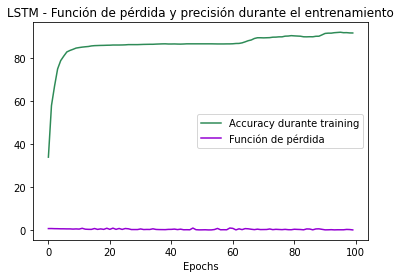

In [ ]:
plt.title('LSTM - Función de pérdida y precisión durante el entrenamiento')
plt.plot(accuracy_train_lstm,color='seagreen')
plt.plot(train_losses_lstm, color='darkviolet')

plt.xlabel('Epochs')
plt.legend(['Accuracy durante training', 'Función de pérdida'], loc='center right')
plt.show()

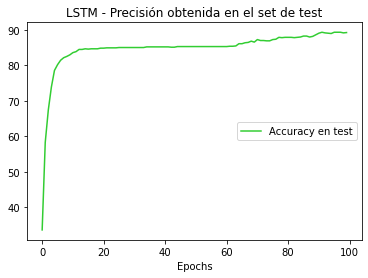

In [ ]:
plt.title('LSTM - Precisión obtenida en el set de test')
plt.plot(accuracy_test_lstm,color='limegreen')
plt.xlabel('Epochs')
plt.legend(['Accuracy en test'], loc='center right')
plt.show()

## Actividad 5
Considerando el mejor modelo de las actividades anteriores. Pruebe las siguientes variantes y comente brevemente sobre los resultados obtenidos y la velocidad de convergencia.

• **5.1  Pruebe agregando una segunda capa de red recurrente. Comente brevemente sobre los resultados obtenidos y la velocidad de convergencia.**

**Respuesta:** El mejor modelo de los anteriores fue LSTM, por lo que creó el modelo **model_lstm_2capas** agregando una segunda capa recurrente al modelo LSTM: `self.lstm2= torch.nn.LSTM(hidden_dim,hidden_dim)`. Este quedó con  210,442  parámeteros entrenables, se obtuvo 94.14% de accuracy en training, 94.47% en validación y 93.36% en test. Tardó en entrenar solo 8 segundos más que el LSTM anterior, la velocidad de convergencia fue similar a los experimentos anteriores, manteniendo una loss a la baja y disminuyendo desde la epoch 1 con 0.6866 a la epoch 100 con 0.1629. En celdas posteriores se encuentra el código y gráficos que apoyan el experimento.


• **5.2 Pruebe utilizando una RNN bidireccional de 1 capa de profundidad, varie la dimensión de los embeddings y de la capa lineal en ambas direcciones.**

**Respuesta:** Se experimentó con una RNN bidireccional con 1 capa de profundidad, aumentando la dimensión de los embeddings de 100 a 300 `(embedding_dim= 300)`, se cambió la dirección de la capa lineal `(self.fc = torch.nn.Linear(hidden_dim*2, output_dim)`. El modelo obtuvo 95.20% de accuracy en training, 93.72% en validación y 92.64% en test. Tardó en entrenar 46 segundos y la velocidad de convergencia fue buena, aprendió en la mayoria de las epochs, habiendo una tendencia en la curva de testing hacia el alza, la loss fue casi constante desde la epoch 1 con 0.4261 a la epoch 100 con 0.0960.

### 5.1 **LSTM con 2 capas recurrentes**

In [ ]:
class LSTM_2capas(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.lstm1 = torch.nn.LSTM(embedding_dim,hidden_dim)
        self.lstm2= torch.nn.LSTM(hidden_dim,hidden_dim)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.act = torch.nn.LogSoftmax()

    def forward(self, text, text_length):

        embedded = self.embedding(text)

        ## padded_sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'))
        packed_output, (hidden, cell) = self.lstm1(packed)
        packed_output, (hidden, cell) = self.lstm2(packed_output)

        hidden.squeeze_(0)

        output = self.fc(hidden)
        output=  self.act(output)
        return output

#### Instanciaciación modelo LSTM con 2 capas recurrentes

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_lstm_2capas = LSTM_2capas(input_dim=len(TEXT.vocab),
            embedding_dim= EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim= 2
)

model_lstm_2capas = model_lstm_2capas.to(DEVICE)
optimizer = torch.optim.Adam(model_lstm_2capas.parameters(), lr= LEARNING_RATE)

**Cantidad de parámetros para el modelo LSTM_2capas**

In [ ]:
print(f'El modelo model_lstm_2capas tiene  {num_trainable_parameters(model_lstm_2capas):,}  parámeteros entrenables')

El modelo model_lstm_2capas tiene  210,442  parámeteros entrenables


#### Entrenamiento LSTM_2capas

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch_data in enumerate(data_loader):

            # LOGITS
            features, text_length = batch_data.message
            targets = batch_data.label.to(DEVICE)

            logits = model(features, text_length)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
train_losses_lstm_2c = []
accuracy_train_lstm_2c = []
accuracy_test_lstm_2c = []

for epoch in range(NUM_EPOCHS):
    model_lstm_2capas.train()
    for batch_idx, batch_data in enumerate(train_loader):

        # features y labels
        features, text_length = batch_data.message
        labels = batch_data.label.to(DEVICE)

        ### FOorward y back propagation
        logits = model_lstm_2capas(features, text_length)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward(retain_graph = True)

        train_losses_lstm_2c.append(loss)
        accuracy_train_lstm_2c.append(compute_accuracy(model_lstm_2capas, train_loader, DEVICE))
        accuracy_test_lstm_2c.append(compute_accuracy(model_lstm_2capas, test_loader, DEVICE))

        ### actualización de los parámetros del modelo
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy LSTM  2 capas: '
              f'{compute_accuracy(model_lstm_2capas, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy LSTM  2 capas: '
              f'{compute_accuracy(model_lstm_2capas, val_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time LSTM 2 capas: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy LSTM  2 capas: {compute_accuracy(model_lstm_2capas, test_loader, DEVICE):.2f}%')

Epoch: 001/100 | Batch 000/060 | Loss: 0.6866
training accuracy LSTM  2 capas: 86.28%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.00 min
Epoch: 002/100 | Batch 000/060 | Loss: 0.6612
training accuracy LSTM  2 capas: 86.57%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.01 min
Epoch: 003/100 | Batch 000/060 | Loss: 0.6400
training accuracy LSTM  2 capas: 86.62%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.01 min
Epoch: 004/100 | Batch 000/060 | Loss: 0.6152
training accuracy LSTM  2 capas: 86.62%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.02 min
Epoch: 005/100 | Batch 000/060 | Loss: 0.6550
training accuracy LSTM  2 capas: 86.62%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.02 min
Epoch: 006/100 | Batch 000/060 | Loss: 0.7133
training accuracy LSTM  2 capas: 86.62%
valid accuracy LSTM  2 capas: 88.64%
Time elapsed: 0.03 min
Epoch: 007/100 | Batch 000/060 | Loss: 0.5532
training accuracy LSTM  2 capas: 86.62%
valid accuracy LSTM  2 capas: 88.64%
T

#### Gráficos de desempeño de LSTM 2 capas

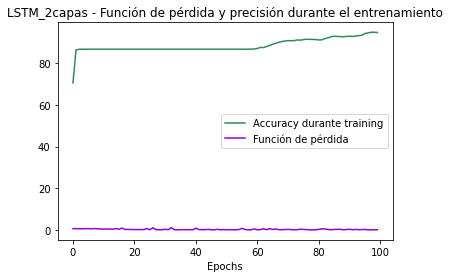

In [ ]:
plt.title('LSTM_2capas - Función de pérdida y precisión durante el entrenamiento')
plt.plot(accuracy_train_lstm_2c,color='seagreen')
plt.plot(train_losses_lstm_2c, color='darkviolet')

plt.xlabel('Epochs')
plt.legend(['Accuracy durante training', 'Función de pérdida'], loc='center right')
plt.show()

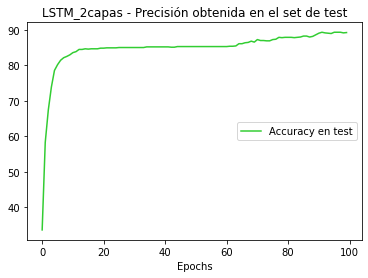

In [ ]:
plt.title('LSTM_2capas - Precisión obtenida en el set de test')
plt.plot(accuracy_test_lstm,color='limegreen')
plt.xlabel('Epochs')
plt.legend(['Accuracy en test'], loc='center right')
plt.show()

### 5.2 **RNN Bidireccional**

Se prueba una RNN bidireccional aumentando la dimensión de la capa lineal `(hidden_dim*2)`y la dimensión de los embedding

In [ ]:
class RNN_bidirectional(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, bidirectional =True):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim,
                               hidden_dim,
                               nonlinearity='relu',
                                bidirectional =  True)

        self.fc = torch.nn.Linear(hidden_dim*2, output_dim)
        self.act = torch.nn.LogSoftmax()

    def forward(self, text, text_length):

        embedded = self.embedding(text)

        ## Packed
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'))
        packed_output, hidden = self.rnn(packed)
        rnn_bi_out = torch.cat((hidden[0], hidden[1]), dim = 1)

        hidden.squeeze_(0)

        output = self.fc(rnn_bi_out)
        output=  self.act(output)
        return output

In [ ]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE, vectors = 'glove.6B.300d')
LABEL.build_vocab(train_data)
embedding_300d = TEXT.vocab.vectors.to(DEVICE)

#### Instanciaciación modelo RNN_bidirectional

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_rnn_bi = RNN_bidirectional(input_dim=len(TEXT.vocab),embedding_dim= embedding_300d.shape[1],
                                 hidden_dim=HIDDEN_DIM,output_dim= 2,bidirectional = True)

model_rnn_bi = model_rnn_bi.to(DEVICE)
optimizer = torch.optim.Adam(model_rnn_bi.parameters(), lr= LEARNING_RATE)

#### Entrenamiento RNN_bidirectional

In [ ]:
start_time = time.time()
train_losses_rnn_bi = []
acc_train_rnn_bi = []
acc_test_rnn_bi = []

for epoch in range(NUM_EPOCHS):
    model_rnn_bi.train()
    for batch_idx, batch_data in enumerate(train_loader):

        # feaures y labels
        features, text_length = batch_data.message
        labels = batch_data.label.to(DEVICE)

        ### Forward y back propagation
        logits = model_rnn_bi(features, text_length)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward(retain_graph = True)

        train_losses_rnn_bi.append(loss)
        acc_train_rnn_bi.append(compute_accuracy(model_rnn_bi, train_loader, DEVICE))
        acc_test_rnn_bi.append(compute_accuracy(model_rnn_bi, train_loader, DEVICE))

        ### actualización de parámetros del modelo
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'RNN Bi training accuracy: '
              f'{compute_accuracy(model_rnn_bi, train_loader, DEVICE):.2f}%'
              f'\n RNN Bi valid accuracy: '
              f'{compute_accuracy(model_rnn_bi, val_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'RNN Bi Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'RNN Bi Test accuracy: {compute_accuracy(model_rnn_bi, test_loader, DEVICE):.2f}%')

Epoch: 001/100 | Batch 000/060 | Loss: 0.4261
RNN Bi training accuracy: 86.51%
 RNN Bi valid accuracy: 88.19%
Time elapsed: 0.01 min
Epoch: 002/100 | Batch 000/060 | Loss: 0.2632
RNN Bi training accuracy: 86.57%
 RNN Bi valid accuracy: 88.64%
Time elapsed: 0.01 min
Epoch: 003/100 | Batch 000/060 | Loss: 0.9158
RNN Bi training accuracy: 86.59%
 RNN Bi valid accuracy: 88.64%
Time elapsed: 0.01 min
Epoch: 004/100 | Batch 000/060 | Loss: 0.6324
RNN Bi training accuracy: 86.59%
 RNN Bi valid accuracy: 88.49%
Time elapsed: 0.02 min
Epoch: 005/100 | Batch 000/060 | Loss: 0.1257
RNN Bi training accuracy: 86.59%
 RNN Bi valid accuracy: 88.79%
Time elapsed: 0.02 min
Epoch: 006/100 | Batch 000/060 | Loss: 0.7187
RNN Bi training accuracy: 86.86%
 RNN Bi valid accuracy: 87.59%
Time elapsed: 0.03 min
Epoch: 007/100 | Batch 000/060 | Loss: 0.1332
RNN Bi training accuracy: 86.70%
 RNN Bi valid accuracy: 87.14%
Time elapsed: 0.03 min
Epoch: 008/100 | Batch 000/060 | Loss: 0.1201
RNN Bi training accurac

#### Gráficos de desempeño de RNN Bidireccional

<function matplotlib.pyplot.show(close=None, block=None)>

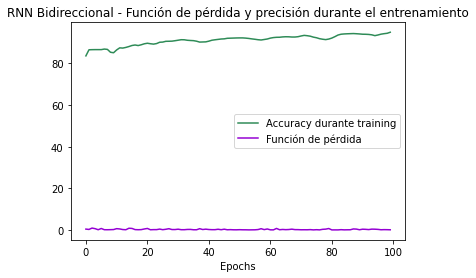

In [ ]:
plt.title('RNN Bidireccional - Función de pérdida y precisión durante el entrenamiento')
plt.plot(acc_train_rnn_bi,color='seagreen')
plt.plot(train_losses_rnn_bi, color='darkviolet')

plt.xlabel('Epochs')
plt.legend(['Accuracy durante training', 'Función de pérdida'], loc='center right')
plt.show

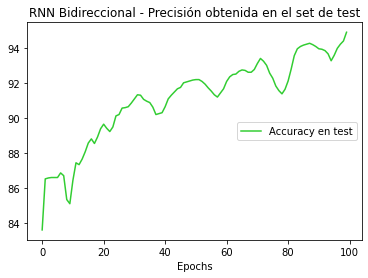

In [ ]:
plt.title('RNN Bidireccional - Precisión obtenida en el set de test')
plt.plot(acc_test_rnn_bi,color='limegreen')
plt.xlabel('Epochs')
plt.legend(['Accuracy en test'], loc='center right')
plt.show()

# II.PARTE 2: Red Siamesa para Aprendizaje de Similitud entre Oraciones (60%)

En esta parte de la tarea trabajaremos con redes siamesas. Este tipo de arquitectura se utiliza comunmente para aprender una métrica de distancia semaántica entre las entidades de entrada al modelo. A modo de ejemplo, la figura 2 muestra el caso de una red siamesa que es utilizada para aprender una métrica de similitud entre las 2 imágenes de entrada.

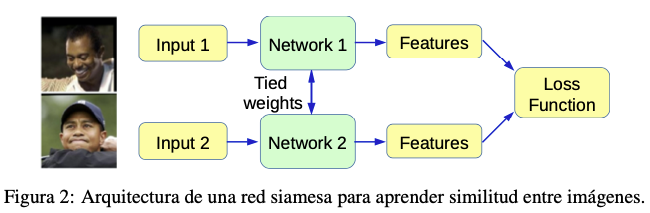


En la figura 2, las redes 1 y 2 (“Network 1” y “Network 2”) utilizan el mismo set de pesos (tied weights). Además, a la salida de estas redes, el bloque “Features” corresponde al vector de característica de la última capa de las redes 1 y 2. Este vector de características es utilizado para calcular la función de pérdida.

Durante el aprendizaje, la función de pérdida tiene como objetivo acercar vectores de features correspondientes a imágenes con similitud semántica y alejar vectores sin este tipo de similitud. Las siguientes ecuaciones muestran dos funciones de pérdida que permiten lograr este objetivo:

i) Pérdida ranking de pares (pairwise ranking loss)

ii) Pérdida ranking de triples (triplet ranking loss).

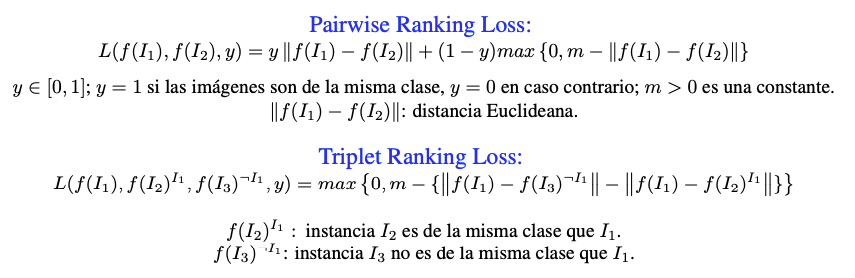

Para el caso de aprender una distancia entre oraciones, las redes 1 y 2 serán del tipo LSTM bidireccionales. Para el entrenamiento usarán el set de datos SICK, disponible en:** SICK-Dataset**: http://marcobaroni.org/composes/sick.html.

Para implementar el modelo, el primer paso será llevar las oraciones de entrada a un espacio de características (embedding), en este caso usarán la codificación Word2Vec, según lo siguiente:


* **Word2Vec** consiste de una red neuronal pre-entrenada con una gran cantidad de textos, que permite codificar cada palabra del idioma inglés a un espacio de características, típicamente de 300 dimensiones, de ahí su nombre Word-To-Vector o simplemente word2vec.

* Para codificar una frase, cada palabra en la frase de entrada se transforma a su codificación word2vec de 300D aplicando el modelo correspondiente. Luego, la codificación de la frase completa se calcula como el vector promedio (average pooling) de las codificaciones de sus palabras.

* Para utilizar la codificación word2vec pueden usar librerías como **Gensim y Pytorch-NLP.**

# 2.1 Modelo - dataset

**Revise el dataset SICK y también su uso para el modelo presentado en J. Mueller, A. Thyagarajan. Siamese Recurrent Architectures for Learning Sentence Similarity. In AAAI-16 2016**

* **1. ¿Qué significan los rótulos de cada oración para este set de datos y como fueron obtenidos?**

 Cada par de oraciones está anotado por la relación en el significado y por la relación de implicación entre los dos elementos.
 Los campos del dataset son:

- pair_ID: sentence pair ID

- sentence_A: sentence A

- sentence_B: sentence B

- entailment_label: textual entailment gold label (NEUTRAL, ENTAILMENT, or CONTRADICTION)

- relatedness_score: semantic relatedness gold score (on a 1-5 continuous scale)

- entailment_AB: entailment for the A-B order (A_neutral_B, A_entails_B, or A_contradicts_B)

- entailment_BA: entailment for the B-A order (B_neutral_A, B_entails_A, or B_contradicts_A)

- sentence_A_original: original sentence from which sentence A is derived

- sentence_B_original: original sentence from which sentence B is derived

- sentence_A_dataset: dataset from which the original sentence A was extracted (FLICKR vs. SEMEVAL)

- sentence_B_dataset: dataset from which the original sentence B was extracted (FLICKR vs. SEMEVAL)

- SemEval_set: set including the sentence pair in SemEval 2014 Task 1 (TRIAL, TRAIN, or TEST)

En el paper, la puntuación de relación semántica de pares cada parde frases se antoan con una etiqueta de relación que va entre [1,5], correspondiente  a la relación promedio juzgado por 10 individuos diferentes. miden con G,S y M

**G:** Ground Truth denota relación [1, 5]

**S:** Skip-thought

**M:** MaLSTM (Manhattan LSTM) predictions

* **2. ¿Cuál es el tamaño del dataset total?**

El conjunto de datos de SICK consta de 10,000 pares de oraciones en inglés, construidos a partir de dos
conjuntos: el conjunto de datos 8K ImageFlickr (http://nlp.cs.illinois.edu/HockenmaierGroup/data.html)
y el conjunto de datos de descripciones de video de similitud textual semántica de SEMEVAL-2012
(http://www.cs.york.ac.uk/semeval-2012/task6/index.php?id=data).Aunque en el paper,mencionan un universo de 9927 pares de oraciones.


*  **3. ¿Cuál es el tamaño de la partición utilizada para entrenamiento y test?.**  En su tarea utilice también estas particiones.

Los datos de SICK usados por Marelli et al.2014, contienen 9927 pares de oraciones con un **5.000 datos para train y  4.927 para test**

# 2.2 Modelo Siamese
El siguiente código muestra una posible estructura que puede utilzar como base para construir su modelo.



```
class Siamese(nn.Module):
  def __init__(self, embeddings_table, embeddings_size_1,
  embeddings_size_2,hidden_size_1,hidden_size_2):
    super().__init__():
    self.embeddings_table = word2vec
    self.embeddings_size_1 = embeddings_size_1
    self.hidden_size_1 = hidden_size1_1
    self.embeddings_size_2 = embeddings_size_2
    self.hidden_size_2 = hidden_size_2
    self.lstm_1 = nn.LSTM(input_size=embeddings_size_1, hidden_size=
      hidden_size_1, bidirectional=True)
    self.lstm_2 = nn.LSTM(input_size=embeddings_size_2, hidden_size=
      hidden_size_2, bidirectional=True)

  def forward(self, src_sentences, src_lengths):
    # ver comentarios siguiente secci\’on para completar
    # TODO: calcule embeddings usando su implementaci\’on de word2vec
    # TODO: ejecute self.lstm sobre los embeddings de las oraciones

    return all_hidden_states, last_hidden_states, last_cell_states
```



## Actividad 6
Complete el código anterior en las partes indicadas con el comentario: [TODO].

Para la función de pérdida seleccione alguna de las 2 métricas indicadas anteriormente.

**6.1  Comente brevemente sus decisiones de diseño del modelo.**

**Respuesta:** Para el modelo siamese se crea un objeto de embedding de los pesos pre entrenados, luego se crea una única capa LSTM y se calcula la distnacia manhattan. En la función *forward_once* se ordenan los índices demanera decreciente para preparar los datos para el PAdding y Packing, se recuperan los embeddings y se empaqueta el padded sequenes para pasarlo por la LSTM, finalmente se calculan los puntajes de similaridad entre las oraciones entre pares.

**6.2 ¿Cuántos parámetros entrenables tiene el modelo resultante?**

**Respuesta:** El modelo siamese_model tiene  70,400  parámeteros entrenable

Definición de hiperparámetros

In [ ]:
FILE_PATH = path + '/SICK.txt'
EMBEDDING_PATH = path +'/GoogleNews-vectors-negative300.bin.gz'
EMBEDDING_DIMENSION = 300
EMBEDDING_REQUIRES_GRAD = False
HIDDEN_CELLS = 50
NUM_LAYERS = 1

**Dataset**

Carga de datos

In [ ]:
df_sick = pd.read_csv(FILE_PATH, sep='\t')

In [ ]:
df_sick.sample(5)

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
5231,5368,A man is not riding a scooter,A man is playing a flute,NEUTRAL,1.5,A_neutral_B,B_neutral_A,a man is playing a flute,a man is riding a scooter,SEMEVAL,SEMEVAL,TEST
3054,3094,Some women are dancing,The men are not dancing,NEUTRAL,3.0,A_neutral_B,B_neutral_A,women are dancing,three men are dancing,SEMEVAL,SEMEVAL,TRAIN
1129,1147,A woman is dipping a shrimp in batter,A man is driving a car,NEUTRAL,1.0,A_neutral_B,B_neutral_A,A man is driving a car.,A woman dips a shrimp in batter.,SEMEVAL,SEMEVAL,TRAIN
1257,1275,A man is shaking a drink,A man is mowing a lawn,NEUTRAL,1.6,A_neutral_B,B_neutral_A,A man is mowing a lawn.,A man is mixing.,SEMEVAL,SEMEVAL,TRAIN
2493,2528,A cat is eagerly eating corn on the cob,A cat is eating corn on the cob,ENTAILMENT,4.6,A_entails_B,B_neutral_A,a cat is eating corn on the cob,a cat is eating corn on the cob,SEMEVAL,SEMEVAL,TEST


In [ ]:
scaler = MinMaxScaler().fit(df_sick["relatedness_score"].values.reshape(-1,1))
df_sick["relatedness_score_scaled"] = scaler.transform(df_sick["relatedness_score"].values.reshape(-1,1))

#### **Limpieza de datos**

Se remueven *stop words* y *stem* (forma de la palabra), se transforma todo el dataset a minúsculas y se dividen las palabras (split)
Para esto se utiliza la función `text_to_wordlist` extraída de *https://www.kaggle.com/currie32/the-importance-of-cleaning-text*

In [ ]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()

    #  remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]

    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    # Return a list of words
    text = text.strip()
    return text

Convertir el df en una lista de tuplas, donde cada tupla es la `sentence_A` y `sentence_B`

In [ ]:
sentences_pair = []
train_labels = []
for _, row in df_sick.iterrows():

    s1 = text_to_wordlist(str(row['sentence_A']))
    s2 = text_to_wordlist(str(row['sentence_B']))

    label = row['relatedness_score'] #entailment_label
    if s1 and s2:
        sentences_pair.append((
                s1, s2
            ))
        train_labels.append(label)

print ('Pares de sentencias: ', len(sentences_pair))

Pares de sentencias:  9840


La clase `Language` realiza un seguimiento del vocabulario del dataset y los índices correspondientes.


In [ ]:
class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words + 1
            self.word2count[word] = 1
            self.index2word[self.n_words + 1] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

language = Language()
for data in [sentences_pair]:
    for sen_pair in data:
        s1 = sen_pair[0]
        s2 = sen_pair[1]
        language.addSentence(s1)
        language.addSentence(s2)

Se crea una clase `SentenceDataset`que puede  recuperar el par de oraciones y
la etiqueta correspondiente

In [ ]:
class SentenceDataset(Dataset):
    def __init__(self, sentences_list, word2index, labels):
        self.sentences_list = sentences_list
        self.labels = labels
        self.word2index = word2index

    def __len__(self):
        return len(self.sentences_list)

    def __getitem__(self, index):
        par_oraciones = self.sentences_list[index]
        s1 = par_oraciones[0]
        s1_indices = []
        for word in s1.split():
            s1_indices.append(self.word2index[word])

        s2 = par_oraciones[1]
        s2_indices = []
        for word in s2.split():
            s2_indices.append(self.word2index[word])

        # s1_indices y s2_indices son listas de índices de las palabras utilizadas en la oración
        return s1_indices, s2_indices, self.labels[index]

sick_dataset = SentenceDataset(sentences_pair, language.word2index, train_labels)

In [ ]:
n_vocabulary_words = len(language.word2index)
print ('Total de palabras únicas del vocabulario: ', n_vocabulary_words)

Total de palabras únicas del vocabulario:  2307


`CustomCollate` ajusta los datos en el formato deseado y calcula las longitudes que luego se utilizarán para Padding y packing

In [ ]:
class CustomCollate:
    def custom_collate(self, batch):
        s1_list = []
        s2_list = []
        labels = []
        for training_example in batch:
            s1_list.append(training_example[0])
            s2_list.append(training_example[1])
            labels.append(training_example[2])

        s1_lengths = [len(q) for q in s1_list]
        s2_lengths = [len(q) for q in s2_list]

        return s1_list, s1_lengths, s2_list, s2_lengths, labels

    def __call__(self, batch):
        return self.custom_collate(batch)

#### División de conjuntos de train y test

In [ ]:
test_split = 0.4919

dataset_size = len(sick_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
shuffle_dataset = True
random_seed = 25

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

#Dataloader
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader_siam= torch.utils.data.DataLoader(sick_dataset,
                                               batch_size=1, sampler=train_sampler,
                                               collate_fn=CustomCollate())
test_loader = torch.utils.data.DataLoader(sick_dataset, batch_size=1,
                                         sampler=test_sampler, collate_fn=CustomCollate())

print ('Tamaño set de train {}, Tamaño set de test {}'.format(len(train_indices), len(test_indices)))

Tamaño set de train 5000, Tamaño set de test 4840


#### Matriz de **embedding** - **word2vec**
Para el vocabulario data set utilizando embeddings preentrenados de `Word2Vec`

Se crea un tensor de peso aleatorio `(n_vocabulary_words + 1, EMBEDDING_DIMENSION)` y se coloca el embedding de cada palabra de word2vec en el índice asignado a esa palabra

* 1. El tensor de pesos iniciliza aleatoriamente para que las palabras que forman parte del vocabulario del dataset pero que no están presentes en word2vec reciben un embedding aleatorio.

* 2. Embedding en el índice 0 son todos ceros. Esta es el embedding para el padding que haremos para el batch processing.

In [ ]:
import gensim

In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_PATH, binary=True) # word2vec pre entrenado
word2vec_weights = torch.FloatTensor(word2vec_model.vectors) # convierte word2vec en FLoatTensor

weights = torch.randn(n_vocabulary_words + 1, EMBEDDING_DIMENSION) #random weight tensor and place each word's embedding from word2vec at the index assigned to that word
weights[0] = torch.zeros(EMBEDDING_DIMENSION)
for word, lang_word_index in language.word2index.items():
    if word in word2vec_model:
        weights[lang_word_index] = torch.FloatTensor(word2vec_model.word_vec(word))

del word2vec_model
del word2vec_weights

#### **Red Siamesa**
En el código de la celda siguiente se completa la red propuesta en el enunciado con una capa de **LSTM**

In [ ]:
class Siamese(nn.Module):

    def __init__(self, pretrained_weights):
        super(Siamese, self).__init__()

        # Creating embedding object from the pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)
        self.embedding.weight.requires_grad = EMBEDDING_REQUIRES_GRAD

        # Create a single LSTM since this is a Siamese Network and the weights are shared
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIMENSION,
                            hidden_size=HIDDEN_CELLS,
                            num_layers = NUM_LAYERS,
                            batch_first = True)

    # Manhattan Distance Calculator
    def exponent_neg_manhattan_distance(self, x1, x2):
        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=0)).to(DEVICE)

    def forward_once(self, x, input_lengths):

        # Reverse sequence lengths indices in decreasing order as per the requirement from PyTorch before Padding and Packing
        sorted_indices = np.flipud(np.argsort(input_lengths))
        input_lengths = np.flipud(np.sort(input_lengths))
        input_lengths = input_lengths.copy()
        ordered_questions = [torch.LongTensor(x[i]).to(DEVICE) for i in sorted_indices]

        # Reorder in the decreasing order of their lengths
        ordered_questions = torch.nn.utils.rnn.pad_sequence(ordered_questions, batch_first=True)

        # Retrieve Embeddings
        embeddings = self.embedding(ordered_questions).to(DEVICE)

        # Pack the padded sequences and pass it through LSTM
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, input_lengths, batch_first=True)
        out, (hn, cn) = self.lstm(packed)
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True,
                                                                        total_length=int(input_lengths[0]))

        # reorders the calculated activations to the original order in which sentences were passed
        result = torch.FloatTensor(unpacked.size())
        for i, encoded_matrix in enumerate(unpacked):
            result[sorted_indices[i]] = encoded_matrix
        return result

    def forward(self, s1, s1_lengths, s2, s2_lengths):
        output1 = self.forward_once(s1, s1_lengths)
        output2 = self.forward_once(s2, s2_lengths)
        similarity_score = torch.zeros(output1.size()[0]).to(DEVICE)

        # Calculate Similarity Score between both sentences in a single pair
        for index in range(output1.size()[0]):
            ## Sequence lenghts are being used to index and retrieve the activations before the zero padding since they were not part of original question
            s1 = output1[index, s1_lengths[index] - 1, :]
            s2 = output2[index, s2_lengths[index] - 1, :]
            similarity_score[index] = self.exponent_neg_manhattan_distance(s1, s2)

        return similarity_score

Modelo `siamese_model`

In [ ]:
siamese_model = Siamese(weights).to(DEVICE)

**Cantidad de parámetros para el modelo con 50 dimensiones para el estado oculto**

In [ ]:
print(f'El modelo siamese_model tiene  {num_trainable_parameters(siamese_model):,}  parámeteros entrenables')


El modelo siamese_model tiene  70,400  parámeteros entrenables


## Actividad 7
Entrene su modelo utilizando el dataset SICK:

• **Reporte gráficamente cómo varían la precisión y la función de pérdida conforme avanza el set entrenamiento.**

• **Reporte la precisión obtenida en el set de test.**

#### **Función de pérdida**
Se usará como función de pérdida **MSE** `criterion = nn.MSELoss()`

*Nota: en el enunciado se solicita reportar precisión, sin embargo, este problema regresiona un valor numérico (flotante entre [1,5],no una clase, por lo que se usará MSE como criterion.*
ION.

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr = 0.001)
num_epochs = 10

#### **Entrenamiento Siamese**

In [ ]:
total_step = len(train_loader_siam)
threshold = torch.Tensor([0.5]).to(DEVICE)
siamese_loss=[]
siamese_acc=[]

for epoch in range(num_epochs):
    loss_history = []
    siamese_model.train(True)
    train_correct_total = 0
    for i, (s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths, labels) in enumerate(train_loader_siam):

        labels = torch.Tensor(labels).to(DEVICE)
        optimizer.zero_grad()

        similarity_score = siamese_model(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
        predictions = (similarity_score > threshold).float() * 1
        total = labels.size()[0]
        correct = (predictions == labels).sum().item()
        train_correct_total += correct
        loss = criterion(similarity_score, labels)
        loss.backward()
        optimizer.step()
        siamese_loss.append(loss)

        if (i + 1) % 100 == 0:
            loss_history.append(loss.item())
            print('Epoch [{}/{}], Loss: {:.4f}, Correctas: {:.4f}'.format(epoch + 1,
                                                                          num_epochs, np.mean(loss_history), correct))

    print('Training Loss: {:.4f}'.format(np.mean(loss_history)/ len(train_indices)))

    siamese_model.train(False)
    test_correct_total = 0
    with torch.no_grad():
        for i, (s1_batch, s1_batch_lengths, s2_batch,s2_batch_lengths, labels) in enumerate(test_loader):

            labels = torch.FloatTensor(labels).to(DEVICE)

            similarity_score = siamese_model(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
            predictions = (similarity_score > threshold).float() * 1
            total = labels.size()[0]
            correct = (predictions == labels).sum().item()
            test_correct_total += correct
            #siamese_acc.append(test_correct_total)
            avg_acc_test =  test_correct_total * 100 / len(test_indices)
            siamese_acc.append(avg_acc_test)
            print(avg_acc_test)

Epoch [1/10], Loss: 11.5600, Correctas: 0.0000
Epoch [1/10], Loss: 7.0600, Correctas: 0.0000
Epoch [1/10], Loss: 7.9100, Correctas: 0.0000
Epoch [1/10], Loss: 7.0350, Correctas: 0.0000
Epoch [1/10], Loss: 8.2200, Correctas: 0.0000
Epoch [1/10], Loss: 7.5167, Correctas: 0.0000
Epoch [1/10], Loss: 7.5629, Correctas: 0.0000
Epoch [1/10], Loss: 8.1487, Correctas: 0.0000
Epoch [1/10], Loss: 7.6444, Correctas: 0.0000
Epoch [1/10], Loss: 6.9050, Correctas: 0.0000
Epoch [1/10], Loss: 6.3355, Correctas: 0.0000
Epoch [1/10], Loss: 5.8075, Correctas: 1.0000
Epoch [1/10], Loss: 6.1985, Correctas: 0.0000
Epoch [1/10], Loss: 6.1671, Correctas: 0.0000
Epoch [1/10], Loss: 6.7700, Correctas: 0.0000
Epoch [1/10], Loss: 6.9094, Correctas: 0.0000
Epoch [1/10], Loss: 7.3524, Correctas: 0.0000
Epoch [1/10], Loss: 7.5128, Correctas: 0.0000
Epoch [1/10], Loss: 7.7258, Correctas: 0.0000
Epoch [1/10], Loss: 7.4375, Correctas: 0.0000
Epoch [1/10], Loss: 7.0952, Correctas: 0.0000
Epoch [1/10], Loss: 7.4641, Corre

#### Gráficos

Línea verde indica precisión, amarilla la pérdida:MSELoss

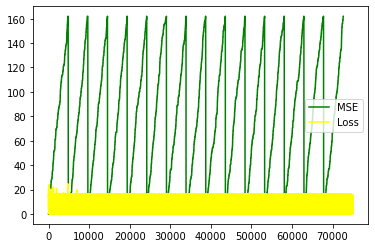

In [ ]:
plt.plot(siamese_acc, color='green')
plt.plot(siamese_loss, color='yellow')
plt.legend(['Precisión','MSE'], loc='center right')
plt.show()

Precisión promedio en test: 3.35
    Se calcula como `test_correct_total * 100 / len(test_indices)`
    
La precisión del modelo es muy baja debido a que no se trata de un problema de clasificación, debería probase en un próximo experimento con nuevos labels, correspondiente a la columna *entailment_label*, que puede tomar 3 clases: NEUTRAL, ENTAILMENT o CONTRADICTION).

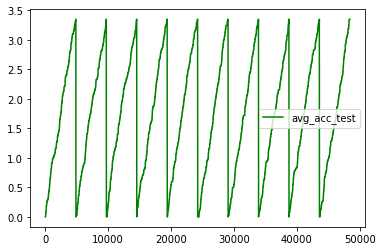

In [ ]:
plt.plot(siamese_acc, color='green')
plt.legend(['avg_acc_test'], loc='center right')
plt.show()

In [ ]:
print("Precisión promedio obtenida en test: ", avg_acc_test)

Precisión obtenida en test:  3.347107438016529



# 2.3 Aumento de datos
Como hemos visto en clases, los modelos de aprendizaje profundo necesitan de grandes cantidades de datos rotulados para alcanzar un buen rendimiento. Como vimos en clases, el uso de técnicas de aumento de datos (data augmentation) sirve para aliviar este problema. Averigue sobre técnicas de aumento de datos usadas comunmente para el caso de textos. Por ejemplo:

  * Reemplazar palabras frecuentes en forma aleatoria por sinónimos.

  * Reemplazar palabras poco frecuentes en forma aleatoria por un anto ́nimo.

  * Traducir a otro idioma y traducir de vuelta.


Seleccione la técnica que desee y apliquela a los datos de SICK, luego entrene su modelo con el set resultante.

### **Técnicas de data augmentation**

Hay técnicas de easy data augmentation para mejorar el rendimiento en tareas con textos. Dada una oración en el set de training, se pueden hacer las siguientes transormaciones: Synonym Replacement (SR),Random Insertion (RI),Random Swap (RS) y Random Deletion (RD).

Descarga de paquetes necesarios de nltk:

In [ ]:
 nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/cami/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/cami/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cami/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cami/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Datos

In [ ]:
df_sick2 = df_sick.copy()

In [ ]:
df_sick2.columns

Index(['pair_ID', 'sentence_A', 'sentence_B', 'entailment_label',
       'relatedness_score', 'entailment_AB', 'entailment_BA',
       'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset',
       'sentence_B_dataset', 'SemEval_set'],
      dtype='object')

In [ ]:
to_drop = ['pair_ID', 'entailment_label',
       'relatedness_score', 'entailment_AB', 'entailment_BA',
       'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset',
       'sentence_B_dataset', 'SemEval_set']
df_sick2.drop(to_drop, axis =1, inplace =True)

In [ ]:
df_sick2

,sentence_A,sentence_B
0,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...
1,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...
2,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...
3,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...
4,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...
...,...,...
9835,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...
9836,Someone is boiling okra in a pot,The man is not playing the drums
9837,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...
9838,A man in blue has a yellow ball in the mitt,A man is jumping rope outside


In [ ]:
print(f"El número total de ejemplos que se utilizarán es : {len(df_sick2)}")

El número total de ejemplos que se utilizarán es : 9840


#### **Synonym Replacement (SR)**

Se eligen al azar n palabras de la oración que no sean palabras intermedias. Se reemplaza cada una de estas palabras con uno de sus sinónimos elegidos al azar.

*ref: https://www.kaggle.com/swarajshinde/eda-data-augmentation-techniques-for-text-nlp*

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):

    synonyms = set()

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)

    return list(synonyms)

El número total de ejemplos que se utilizarán es la función `get_synonyms` devolverá una lista preprocesada de sinónimos de la palabra dada.

Ahora reemplazaremos las palabras con sinónimos.

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def synonym_replacement(words, n):

    words = words.split()

    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)

        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1

        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

 Ejemplo de Synonym Replacement

In [ ]:
print(f" Ejemplo de Synonym Replacement: {synonym_replacement('hey man how are you doing',3)}")

 Ejemplo de Synonym Replacement: hey humankind how are you doing


Ahora un ejemplo del dataset, se intentará aumentarlo para crear 3 oraciones adicionales

In [ ]:
trial_sent = df_sick2['sentence_A'][7]
print(trial_sent)

A group of children is playing in the house and there is no man standing in the background


**Creación de 3 oraciones aumentadas por dato**

In [ ]:
for n in range(3):
    print(f" Ejemplo de Synonym Replacement:: {synonym_replacement(trial_sent,n)}")

 Ejemplo de Synonym Replacement:: A group of children is playing in the house and there is no isle of man standing in the background
 Ejemplo de Synonym Replacement:: A chemical group of children is playing in the house and there is no man standing in the background
 Ejemplo de Synonym Replacement:: group a group of children is playing in the house and there is no man standing in the background knowledge


#### **Creación del dataframe aumentado**
con 1/3 de los registros del set original

In [ ]:
print(f"El número total de ejemplos del df original : {len(df_sick2)}")

El número total de ejemplos del df original : 9840


In [ ]:
print(f"El número total de ejemplos que se utilizarán en el set aumentado es : {len(df_sick2)/3}")

El número total de ejemplos que se utilizarán en el set aumentado es : 3280.0


In [ ]:
df_sick_aum = df_sick[:3280]

In [ ]:
for i in range(3280):
    df_sick_aum['sentence_A'][i] = synonym_replacement(df_sick_aum['sentence_A'][i],1)
    df_sick_aum['sentence_B'][i] = synonym_replacement(df_sick_aum['sentence_B'][i],1)

In [ ]:
df_sick_concat = pd.concat([df_sick_aum, df_sick])

In [ ]:
df_sick_concat.sample(3)

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
3059,3100,A man is ball over a sitting guitar player,type a man is sitting on the floor and is play...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,a man sitting on the floor plays a guitar,a man sitting on the floor plays a guitar,SEMEVAL,SEMEVAL,TRAIN
3959,4042,The person is riding a jetski in the waves,A woman is riding a Seadoo,NEUTRAL,4.3,A_neutral_B,B_neutral_A,a person is riding a jetski in the waves,a woman is riding a seadoo,SEMEVAL,SEMEVAL,TEST
5631,5775,A man is riding a bicycle,There is no man riding an electric bicycle,NEUTRAL,3.5,A_neutral_B,B_neutral_A,a man is riding a bicycle,a man is riding an electric bicycle,SEMEVAL,SEMEVAL,TEST


#### **Entrenamiento con data augmentation**

Se llamarán todas las clases usadas en la actividad 6 y 7.

In [ ]:
sentences_pair2 = []
train_labels2 = []
for _, row in df_sick_concat.iterrows():

    s1 = text_to_wordlist(str(row['sentence_A']))
    s2 = text_to_wordlist(str(row['sentence_B']))

    label = row['relatedness_score']
    if s1 and s2:
        sentences_pair2.append((
                s1, s2
            ))
        train_labels2.append(label)

print ('Pares de sentencias: ', len(sentences_pair2))

Pares de sentencias:  13120


In [ ]:
class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words + 1
            self.word2count[word] = 1
            self.index2word[self.n_words + 1] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

language = Language()
for data in [sentences_pair2]:
    for sen_pair in data:
        s1 = sen_pair[0]
        s2 = sen_pair[1]
        language.addSentence(s1)
        language.addSentence(s2)

In [ ]:
class SentenceDataset(Dataset):
    def __init__(self, sentences_list, word2index, labels):
        self.sentences_list = sentences_list
        self.labels = labels
        self.word2index = word2index

    def __len__(self):
        return len(self.sentences_list)

    def __getitem__(self, index):
        par_oraciones = self.sentences_list[index]
        s1 = par_oraciones[0]
        s1_indices = []
        for word in s1.split():
            s1_indices.append(self.word2index[word])

        s2 = par_oraciones[1]
        s2_indices = []
        for word in s2.split():
            s2_indices.append(self.word2index[word])

        # s1_indices y s2_indices son listas de índices de las palabras utilizadas en la oración
        return s1_indices, s2_indices, self.labels[index]

sick_dataset_augment = SentenceDataset(sentences_pair2, language.word2index, train_labels2)

In [ ]:
n_vocabulary_words = len(language.word2index)
print ('Total de palabras únicas del vocabulario: ', n_vocabulary_words)

Total de palabras únicas del vocabulario:  4009


In [ ]:
class CustomCollate:
    def custom_collate(self, batch):
        s1_list = []
        s2_list = []
        labels = []
        for training_example in batch:
            s1_list.append(training_example[0])
            s2_list.append(training_example[1])
            labels.append(training_example[2])

        s1_lengths = [len(q) for q in s1_list]
        s2_lengths = [len(q) for q in s2_list]

        return s1_list, s1_lengths, s2_list, s2_lengths, labels

    def __call__(self, batch):
        return self.custom_collate(batch)

In [ ]:
test_split = 0.4919

dataset_size = len(sick_dataset_augment)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
shuffle_dataset = True
random_seed = 25

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

#Dataloader
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader_siam= torch.utils.data.DataLoader(sick_dataset_augment,
                                               batch_size=32, sampler=train_sampler,
                                               collate_fn=CustomCollate())
test_loader = torch.utils.data.DataLoader(sick_dataset_augment, batch_size=32,
                                         sampler=test_sampler, collate_fn=CustomCollate())

print ('Tamaño set de train {}, Tamaño set de test {}'.format(len(train_indices), len(test_indices)))

Tamaño set de train 6667, Tamaño set de test 6453


In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_PATH, binary=True) # word2vec pre entrenado
word2vec_weights = torch.FloatTensor(word2vec_model.vectors) # convierte word2vec en FLoatTensor

weights = torch.randn(n_vocabulary_words + 1, EMBEDDING_DIMENSION) #random weight tensor and place each word's embedding from word2vec at the index assigned to that word
weights[0] = torch.zeros(EMBEDDING_DIMENSION)
for word, lang_word_index in language.word2index.items():
    if word in word2vec_model:
        weights[lang_word_index] = torch.FloatTensor(word2vec_model.word_vec(word))

del word2vec_model
del word2vec_weights

**Red siamesa con datos aumentados**

In [ ]:
class SiameseAugm(nn.Module):

    def __init__(self, pretrained_weights):
        super(SiameseAugm, self).__init__()

        # Creating embedding object from the pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)
        self.embedding.weight.requires_grad = EMBEDDING_REQUIRES_GRAD

        # Create a single LSTM since this is a Siamese Network and the weights are shared
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIMENSION,
                            hidden_size=HIDDEN_CELLS,
                            num_layers = NUM_LAYERS,
                            batch_first = True)

    # Manhattan Distance Calculator
    def exponent_neg_manhattan_distance(self, x1, x2):
        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=0)).to(DEVICE)

    def forward_once(self, x, input_lengths):

        # Reverse sequence lengths indices in decreasing order as per the requirement from PyTorch before Padding and Packing
        sorted_indices = np.flipud(np.argsort(input_lengths))
        input_lengths = np.flipud(np.sort(input_lengths))
        input_lengths = input_lengths.copy()
        ordered_questions = [torch.LongTensor(x[i]).to(DEVICE) for i in sorted_indices]

        # Reorder in the decreasing order of their lengths
        ordered_questions = torch.nn.utils.rnn.pad_sequence(ordered_questions, batch_first=True)

        # Retrieve Embeddings
        embeddings = self.embedding(ordered_questions).to(DEVICE)

        # Pack the padded sequences and pass it through LSTM
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, input_lengths, batch_first=True)
        out, (hn, cn) = self.lstm(packed)
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True,
                                                                        total_length=int(input_lengths[0]))

        # reorders the calculated activations to the original order in which sentences were passed
        result = torch.FloatTensor(unpacked.size())
        for i, encoded_matrix in enumerate(unpacked):
            result[sorted_indices[i]] = encoded_matrix
        return result

    def forward(self, s1, s1_lengths, s2, s2_lengths):
        output1 = self.forward_once(s1, s1_lengths)
        output2 = self.forward_once(s2, s2_lengths)
        similarity_score = torch.zeros(output1.size()[0]).to(DEVICE)

        # Calculate Similarity Score between both sentences in a single pair
        for index in range(output1.size()[0]):
            ## Sequence lenghts are being used to index and retrieve the activations before the zero padding since they were not part of original question
            s1 = output1[index, s1_lengths[index] - 1, :]
            s2 = output2[index, s2_lengths[index] - 1, :]
            similarity_score[index] = self.exponent_neg_manhattan_distance(s1, s2)

        return similarity_score

In [ ]:
siamese_model_augm = SiameseAugm(weights).to(DEVICE)

In [ ]:
print(f'El modelo siamese_model_augm tiene  {num_trainable_parameters(siamese_model_augm):,}  parámeteros entrenables')

El modelo siamese_model_augm tiene  70,400  parámeteros entrenables


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(siamese_model_augm.parameters(), lr = 0.001)
num_epochs = 10

In [ ]:
total_step = len(train_loader_siam)
threshold = torch.Tensor([0.5]).to(DEVICE)

siamese_loss_augm=[]
siamese_acc_augm=[]
siamese_acc_augm2=[]

for epoch in range(num_epochs):
    loss_history = []
    siamese_model_augm.train(True)
    train_correct_total = 0
    for i, (s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths, labels) in enumerate(train_loader_siam):

        labels = torch.Tensor(labels).to(DEVICE)
        optimizer.zero_grad()

        similarity_score = siamese_model_augm(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
        predictions = (similarity_score > threshold).float() * 1
        total = labels.size()[0]
        correct = (predictions == labels).sum().item()
        train_correct_total += correct
        loss = criterion(similarity_score, labels)
        loss.backward()
        optimizer.step()
        siamese_loss_augm.append(loss)

        if (i + 1) % 100 == 0:
            loss_history.append(loss.item())
            print('Epoch [{}/{}], Loss: {:.4f}, Correctas: {:.4f}'.format(epoch + 1,
                                                                          num_epochs, np.mean(loss_history), correct))

    print('Training Loss: {:.4f}'.format(np.mean(loss_history)/ len(train_indices)))

    siamese_model_augm.train(False)
    test_correct_total = 0
    with torch.no_grad():
        for i, (s1_batch, s1_batch_lengths, s2_batch,s2_batch_lengths, labels) in enumerate(test_loader):

            labels = torch.FloatTensor(labels).to(DEVICE)

            similarity_score = siamese_model_augm(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
            predictions = (similarity_score > threshold).float() * 1
            total = labels.size()[0]
            correct = (predictions == labels).sum().item()
            test_correct_total += correct
            #siamese_acc.append(test_correct_total)
            avg_acc_test =  test_correct_total * 100 / len(test_indices)
            siamese_acc_augm.append(avg_acc_test)
            siamese_acc_augm2.append((train_correct_total/ len(test_indices))*100)
            print(avg_acc_test)

Epoch [1/10], Loss: 7.1908, Correctas: 0.0000
Epoch [1/10], Loss: 7.2406, Correctas: 0.0000
Training Loss: 0.0011
0.015496668216333487
0.030993336432666975
0.030993336432666975
0.030993336432666975
0.07748334108166745
0.10847667751433442
0.1549666821633349
0.1549666821633349
0.17046335037966837
0.18596001859600186
0.20145668681233536
0.23245002324500233
0.2634433596776693
0.2634433596776693
0.2634433596776693
0.2789400278940028
0.2789400278940028
0.2789400278940028
0.2944366961103363
0.3099333643266698
0.3099333643266698
0.32543003254300323
0.32543003254300323
0.32543003254300323
0.32543003254300323
0.34092670075933673
0.35642336897567023
0.43390671005733766
0.43390671005733766
0.46490004649000466
0.46490004649000466
0.4958933829226716
0.4958933829226716
0.5268867193553386
0.5578800557880056
0.573376724004339
0.604370060437006
0.635363396869673
0.6508600650860065
0.6508600650860065
0.66635673330234
0.66635673330234
0.6818534015186735
0.6818534015186735
0.6818534015186735
0.697350069735

## Actividad 8

* **Explique brevemente la técnica seleccionada (no tiene por que ser una de las mencionadas) y como la aplicó en su tarea.**

 Se eligió Synonym Replacement (SR), en esta técnica se eligen al azar n palabras de la oración que no sean palabras intermedias. Se reemplaza cada una de estas palabras con uno de sus sinónimos elegidos al azar.

En este experimento se probó en una fracción del dataset original lo siguiente:

1. El número total de ejemplos que se utilizaron es la función `get_synonyms` devolvió una lista preprocesada de sinónimos de la palabra dada.

2. Ahora se reemplazan las palabras con sinónimos.

3. Se visualizó un ejemplo del dataset, se aumentarlo para crear 3 oraciones adicionales:

 `Ejemplo de Synonym Replacement:: A group of children is playing in the house and there is no isle of man standing in the background`

 `Ejemplo de Synonym Replacement:: A chemical group of children is playing in the house and there is no man standing in the background`

 `Ejemplo de Synonym Replacement:: group a group of children is playing in the house and there is no man standing in the background knowledge`

4. Se creó un dataframe aumentado con 1/3 de los registros del set original

5. Se entrenó con el nuevo dataframe



ref: https://www.kaggle.com/swarajshinde/eda-data-augmentation-techniques-for-text-nlp


* **Indique además el tamaño del set de entrenamiento resultante.**

El número total de ejemplos que se utilizaron en el set aumentado es : 3280.0

* **Reporte gráficamente cómo varían la precisión y la función de pérdida conforme avanza el entrenamiento.**

Compare el rendimiento en el set de test con respecto al obtenido en la actividad anterior.

Ambos modelos tienen mal desempeño, bordeando un accuracy de 3%.

| rendimiento set de test | Siamesa sin data augmentation | Siamesa con data augmentation |
|-------------------------|:-----------------------------:|:-----------------------------:|
|           ACC           |             3,34%             |             3,17%             |

Es necesario generar más experimentos para mejorar el desempeño

#### **Gráficos**
Precisión y función de pérdida conforme avanza el entrenamiento.

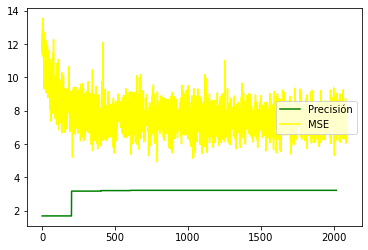

In [ ]:
plt.plot(siamese_acc_augm2, color='green')
plt.plot(siamese_loss_augm, color='yellow')
plt.legend(['Precisión','MSE'], loc='center right')
plt.show()

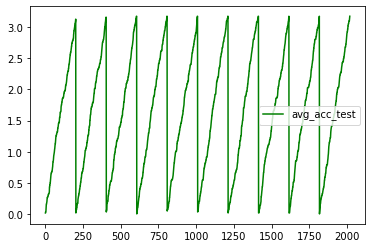

In [ ]:
plt.plot(siamese_acc_augm, color='green')
plt.legend(['avg_acc_test'], loc='center right')
plt.show()

In [ ]:
print("Precisión promedio obtenida en test: ", avg_acc_test)

Precisión promedio obtenida en test:  3.176816984348365


#### **Comparación ambos modelos**

Ambos modelos tienen mal desempeño, bordeando un accuracy de 3%.

| rendimiento set de test | Siamesa sin data augmentation | Siamesa con data augmentation |
|-------------------------|:-----------------------------:|:-----------------------------:|
|           ACC           |             3,34%             |             3,17%             |

Es necesario generar más experimentos para mejorar el desempeño.

# 2.4 Visualización
Selecciones un subconjunto de sus datos de entrenamiento, ej. 30% de los datos. Utilizando su mejor modelo, calcule el feature vector (salida del modelo) para cada una de las oraciones del subconjunto seleccionado. Aplique a los features resultante la técnica **t-SNE** para *reducir la dimensionalidad* de cada vector a un espacio 2D. Existen diversas librerías de Python que incorporan T-SNE.


* Grafique los puntos resultantes y analice cualitativamente los embedding resultantes. Comente brevemente sobre la coherencia semántica del espacio resultante.

* ¿Observa algun(os) cluster(s) significativo(s)?

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
test_split = 0.3

dataset_size = len(sick_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
shuffle_dataset = True
random_seed = 25

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

#Dataloader
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader_siam= torch.utils.data.DataLoader(sick_dataset,
                                               batch_size=1, sampler=train_sampler,
                                               collate_fn=CustomCollate())
test_loader = torch.utils.data.DataLoader(sick_dataset, batch_size=1,
                                         sampler=test_sampler, collate_fn=CustomCollate())

print ('Tamaño set de train {}, Tamaño set de test {}'.format(len(train_indices), len(test_indices)))

Tamaño set de train 6888, Tamaño set de test 2952


Redefinimos la clase pararetornar los vectores de representación de las sentencias en el método`forward`:

In [ ]:
class Siamese_WithFeatVec(nn.Module):

    def __init__(self, pretrained_weights):
        super(Siamese_WithFeatVec, self).__init__()

        # Creating embedding object from the pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)
        self.embedding.weight.requires_grad = EMBEDDING_REQUIRES_GRAD

        # Create a single LSTM since this is a Siamese Network and the weights are shared
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIMENSION,
                            hidden_size=HIDDEN_CELLS,
                            num_layers = NUM_LAYERS,
                            batch_first = True)

    # Manhattan Distance Calculator
    def exponent_neg_manhattan_distance(self, x1, x2):
        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=0)).to(DEVICE)

    def forward_once(self, x, input_lengths):

        # Reverse sequence lengths indices in decreasing order as per the requirement from PyTorch before Padding and Packing
        sorted_indices = np.flipud(np.argsort(input_lengths))
        input_lengths = np.flipud(np.sort(input_lengths))
        input_lengths = input_lengths.copy()
        ordered_questions = [torch.LongTensor(x[i]).to(DEVICE) for i in sorted_indices]

        # Reorder in the decreasing order of their lengths
        ordered_questions = torch.nn.utils.rnn.pad_sequence(ordered_questions, batch_first=True)

        # Retrieve Embeddings
        embeddings = self.embedding(ordered_questions).to(DEVICE)

        # Pack the padded sequences and pass it through LSTM
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, input_lengths, batch_first=True)
        out, (hn, cn) = self.lstm(packed)
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True,
                                                                        total_length=int(input_lengths[0]))

        # reorders the calculated activations to the original order in which sentences were passed
        result = torch.FloatTensor(unpacked.size())
        for i, encoded_matrix in enumerate(unpacked):
            result[sorted_indices[i]] = encoded_matrix
        return result

    def forward(self, s1, s1_lengths, s2, s2_lengths):
        output1 = self.forward_once(s1, s1_lengths)
        output2 = self.forward_once(s2, s2_lengths)
        similarity_score = torch.zeros(output1.size()[0]).to(DEVICE)

        # Calculate Similarity Score between both sentences in a single pair
        for index in range(output1.size()[0]):
            ## Sequence lenghts are being used to index and retrieve the activations before the zero padding since they were not part of original question
            s1 = output1[index, s1_lengths[index] - 1, :]
            s2 = output2[index, s2_lengths[index] - 1, :]
            similarity_score[index] = self.exponent_neg_manhattan_distance(s1, s2)

        return similarity_score, s1, s2

In [ ]:
model_viz = Siamese_WithFeatVec(weights).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_viz.parameters(), lr = 0.001)
num_epochs = 10


In [ ]:
total_step = len(train_loader_siam)
threshold = torch.Tensor([0.5]).to(DEVICE)
siamese_loss=[]
siamese_acc=[]
representations = [] # Guardara las representaciones generadas por el modelo para cada par de sentencias


for epoch in range(num_epochs):
    loss_history = []
    model_viz.train(True)
    train_correct_total = 0
    for i, (s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths, labels) in enumerate(train_loader_siam):

        labels = torch.Tensor(labels).to(DEVICE)
        optimizer.zero_grad()

        similarity_score, _, _ = model_viz(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)

        predictions = (similarity_score > threshold).float() * 1
        total = labels.size()[0]
        correct = (predictions == labels).sum().item()
        train_correct_total += correct
        loss = criterion(similarity_score, labels)
        loss.backward()
        optimizer.step()
        siamese_loss.append(loss)

        if (i + 1) % 100 == 0:
            loss_history.append(loss.item())
            print('Epoch [{}/{}], Loss: {:.4f}, Correctas: {:.4f}'.format(epoch + 1,
                                                                          num_epochs, np.mean(loss_history), correct))

    print('Training Loss: {:.4f}'.format(np.mean(loss_history)/ len(train_indices)))

    model_viz.train(False)
    test_correct_total = 0
    with torch.no_grad():
        for i, (s1_batch, s1_batch_lengths, s2_batch,s2_batch_lengths, labels) in enumerate(test_loader):

            labels = torch.FloatTensor(labels).to(DEVICE)

            similarity_score, rep1, rep2 = model_viz(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
            representations.append([rep1, rep2])

            predictions = (similarity_score > threshold).float() * 1
            total = labels.size()[0]
            correct = (predictions == labels).sum().item()
            test_correct_total += correct
            #siamese_acc.append(test_correct_total)
            avg_acc_test =  test_correct_total * 100 / len(test_indices)
            siamese_acc.append(avg_acc_test)


Epoch [1/10], Loss: 16.7507, Correctas: 0.0000
Epoch [1/10], Loss: 20.7879, Correctas: 0.0000
Epoch [1/10], Loss: 15.9206, Correctas: 0.0000
Epoch [1/10], Loss: 13.1124, Correctas: 0.0000
Epoch [1/10], Loss: 12.3494, Correctas: 0.0000
Epoch [1/10], Loss: 13.3243, Correctas: 0.0000
Epoch [1/10], Loss: 11.8349, Correctas: 0.0000
Epoch [1/10], Loss: 11.3355, Correctas: 0.0000
Epoch [1/10], Loss: 10.4877, Correctas: 0.0000
Epoch [1/10], Loss: 9.8647, Correctas: 0.0000
Epoch [1/10], Loss: 9.4864, Correctas: 0.0000
Epoch [1/10], Loss: 9.9634, Correctas: 0.0000
Epoch [1/10], Loss: 10.4387, Correctas: 0.0000
Epoch [1/10], Loss: 9.8018, Correctas: 0.0000
Epoch [1/10], Loss: 9.1581, Correctas: 0.0000
Epoch [1/10], Loss: 8.9152, Correctas: 0.0000
Epoch [1/10], Loss: 8.3957, Correctas: 0.0000
Epoch [1/10], Loss: 8.4747, Correctas: 0.0000
Epoch [1/10], Loss: 8.6735, Correctas: 0.0000
Epoch [1/10], Loss: 8.5426, Correctas: 0.0000
Epoch [1/10], Loss: 8.5935, Correctas: 0.0000
Epoch [1/10], Loss: 8.27

In [ ]:
with torch.no_grad():
        for i, (s1_batch, s1_batch_lengths, s2_batch,s2_batch_lengths, labels) in enumerate(test_loader):

            labels = torch.FloatTensor(labels).to(DEVICE)

            similarity_score, rep1, rep2 = model_viz(s1_batch, s1_batch_lengths, s2_batch, s2_batch_lengths)
            representations.append([rep1, rep2])

            predictions = (similarity_score > threshold).float() * 1
            total = labels.size()[0]
            correct = (predictions == labels).sum().item()
            test_correct_total += correct
            #siamese_acc.append(test_correct_total)
            avg_acc_test =  test_correct_total * 100 / len(test_indices)
            siamese_acc.append(avg_acc_test)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()

In [ ]:
flat_representations = [item.cpu().numpy() for sublist in representations for item in sublist]

In [ ]:
reduced_representations =  tsne.fit_transform(flat_representations)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(reduced_representations)

KMeans(n_clusters=3)

In [ ]:
df_cluster = pd.DataFrame({'dim1':[rep[0] for rep in reduced_representations],
                           'dim2': [rep[1] for rep in reduced_representations],
                           'cluster': kmeans.labels_})

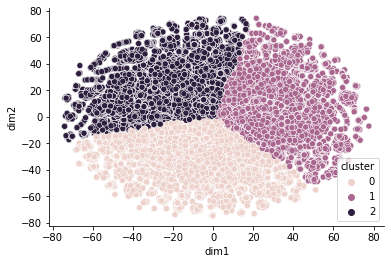

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x = 'dim1', y = 'dim2',  data = df_cluster, hue = 'cluster')
sns.despine()

Las representaciones encontradas en el espacio generado por TSNE muestran una insuficiente capacidad de las representaciones de encontrar similaridad/disimilaridad entre frases, por lo que los clusters observados no corresponden a grupos de oraciones en particular que se distingan de los demás, sino una particion trivial realizada por KMeans sobre un espacio de densidad casi constante en torno al origen

# III. Referencias

1.  D. Bahdanau, K. Cho, and Y. Bengio. Neural machine translation by jointly learning to align and translate. In ICLR, 2015.

2. J. Mueller, A. Thyagarajan. Siamese Recurrent Architectures for Learning Sentence Similarity. In AAAI-16 2016

3. EfficientEstimationofWordRepresentationsinVectorSpace.InarXiv:1301.37812013

4. T.Mikolov,I.Sutskever,K.Chen,G.Corrado,J.Dean.EfficientEstimationofWordRepresentationsinVector Space. In arXiv:1310.4546 2013

5. https://androidkt.com/text-classification-in-pytorch/

6. https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

7. https://torchtext.readthedocs.io/en/latest/data.html

8. https://www.kaggle.com/sauravjoshi23/text-classification-using-siamesenet-glove

9. https://nlp.stanford.edu/pubs/glove.pdf

10. https://github.com/stanfordnlp/GloVe

11. https://github.com/mabdullah1994/Sentence-Similarity-With-Siamese-Network-And-Manhattan-LSTM-PyTorch-/blob/master/Siamese_Network.ipynb

12. https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L15/2_packed-lstm.ipynb

13. https://www.kaggle.com/currie32/the-importance-of-cleaning-text

14. https://github.com/jasonwei20/eda_nlp

15. https://arxiv.org/abs/1901.11196

16. https://maelfabien.github.io/machinelearning/NLP_8/#

17. https://www.kaggle.com/swarajshinde/eda-data-augmentation-techniques-for-text-nlp